In [86]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d 
import seaborn as sns
import time
import pandas as pd
import pickle


## To do

- each montecarlo step involves moving Ns beads, it doesn't mater if some beads is not moved in one step 
  if I repeat many many steps then on average they will be moved.
  
- reject all moves that take me out of the box OR just continue to calculate the fields and stuff outside the box
    ifx interpolation range
    
- make sure that the metroipolis step is working correctly i.e: all the $\Delta U < 0$ are accepted and the probabilities hold

- save the data of the montecarlo as a sepparate file just in case
 
- create the initial chain using a random walk

In [12]:
# load data calcualted from the previous part
wa = np.loadtxt('w_a.csv', delimiter=',')
wb = np.loadtxt('w_b.csv', delimiter=',')

# set up a seed to repeat experiments
np.random.RandomState(seed=111)

RandomState(MT19937) at 0x7FCF91CAA050

In [15]:
# ----------------------
# Global Constants------
# ----------------------
Re = 1.0
# number of points in space 
Nx = 256
# number of beads in the polymer contour
N = 64
# polymer contour
S = np.linspace(0,1,N)
# cutting point of the polymer diving A and B
F = 1/2
L = 2*Re
X = np.linspace(0,Nx, Nx)
X = X*L/Nx


**Steps to take**

1. generate some distribution of random positions for the beads
2. choose a random bead
3. move a this bead a random displacement $\Delta$ in all 3 coordinates, $\Delta$ has to be able to be positive or negative
4. Accept or reject the move according to the metropolis criterion
5. repeat until every single bead in the chain is moved
6. this is one montecarlo step. Repeat many times reach equilibrium

**remember**
- only start to take meassurements after the chain has reached equilibrium
- each bead has to be chosen with a uniform distribution
- the favorable step in the metropolis criterion is the one with lower energy.
- experiment with many $\deltas$ to find the optimal one.
- remember to interpolate the field to calculate their value at intermediate x's
- the fields are constant in y and z

In [49]:
# choose and move one bead of the chain
def move_bead(current_chain,d_interval):
    # selects a bead at random and moves it
    # args-> current_chain: array, contains the positions of the current chain
    #        d_interval: displacement interval
    # returns-> proposed_move: array, chain with one displaced bead
    #           bead_index: index indicating which bead was moved
    Delta = np.random.uniform(low=-d_interval,high=d_interval)

    # chose the bead
    proposed_move = current_chain.copy()
    bead_index = np.random.randint(0,N)
    proposed_move[bead_index,:] = proposed_move[bead_index,:] + Delta
    
    return proposed_move, bead_index

def calculate_energy(bead_chain, no_fields=False):
    # calculates the energy for a given chain
    # args -> bead_chain: array, represents the chain to calculate the energy, includes position for each bead
    #        no_fields: boolean, indicates whether we set the fields to zero or not
    # returns- > U: scalar, the enery of bead_chain
    s1 = []
    swa = []
    swb = []
    
    for i in range(1, len(bead_chain)):
        # first term in U
        s1_mag = bead_chain[i,:] - bead_chain[i-1,:]
        s1.append(np.dot(s1_mag,s1_mag))
        # term dependent on wa remember only the x value is important
        swa_mag = float(wa_int(bead_chain[i,0]))
        swa.append(swa_mag)
        # term dependent on wb
        swb_mag = float(wb_int(bead_chain[i,0]))
        swb.append(swb_mag)
        
    mask_wa = np.zeros(len(swa))
    mask_wb = np.zeros(len(swb))
    
    if no_fields == False:
        # mask wa and wb such that they  act only on their respective sectors of the chain
        mask_wa[:int(F*N)] = 1
        mask_wb[int(F*N):] = 1
        
    # evaluate the sums as dot products
    U = 3*(N-1)/(2*Re**2) * np.sum(s1) + (1/N)*np.dot(mask_wa,swa) + (1/N)*np.dot(mask_wb,swb)
    
    return U, swa, swb, s1

def metropolis_step(d_u, prev_chain, proposed_chain):
    # decides whether to accept the newt move or not
    # args --> d_u: scalar, change in energy between prev_chain and proposed_chain
    #          prev_chain: proposed_chain: arrays. Previous and proposed chain respecively
    # returns: next_chain: the chain for the next step, it can be prev_chain (if rejected) or proposed_chain (if accepted)
    #          accepted: integer. Indicates if the move was accepted (=1) or rejected (=0)
    next_chain = prev_chain.copy()
    accepted = 0
    
    # if negative change we accept    
    if(d_u < 0):
        next_chain = proposed_chain.copy()
        accepted = 1

    else:
        # draw a random number
        coin_toss = np.random.uniform(0,1)
        dist_delta = np.exp(-d_u)

        if(coin_toss<dist_delta):
            next_chain = proposed_chain.copy()
            accepted = 1
            
    return next_chain, accepted
                

### Generating the initial chain
make a list of tuples where each element is the position of each bead in the chain

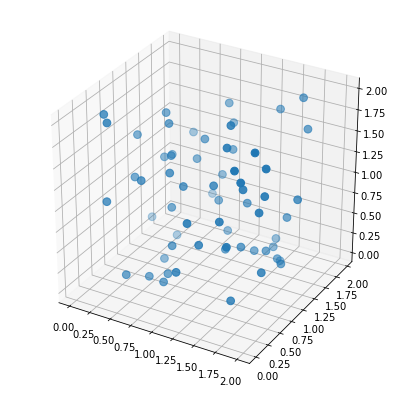

In [5]:
# the chain lives in a box with sides L
# generate the positions of ech of the N beads in s
# rows are the beads, columns the positions of each bead
# xi =  [i,0], yi =  [i,1], zi =  [i,2]
initial_chain = np.random.rand(N,3) * L

# plot them 
plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.scatter3D(initial_chain[:,0], initial_chain[:,1], initial_chain[:,2], s=60);


# Single Montecarlo Step

In [106]:
# for now choose this as place holder value
d = X[1]-X[0] 
# interpolation of the fields
wa_int = interp1d(X,wa, kind='linear')
wb_int = interp1d(X,wb, kind='linear')

current_chain = initial_chain.copy()
delta_u_list = []
acceptance_list = np.zeros(Nx)

# Iterate up to the number of beads in the chain
for i in range(0,Nx):
    next_chain, bead_i = move_bead(current_chain,d)
    
    # ask if the proposed move is inside the box
    if all((y <= L) and (y>=0) for y in next_chain[bead_i]):
        # calculate initial and final energies
        u0,sumwa0, sumwb0, sum0 = calculate_energy(current_chain, no_fields=True)
        uf,sumwaf, sumwbf, sumf = calculate_energy(next_chain, no_fields=True)

        delta_u = uf-u0
        delta_u_list.append(delta_u)
    
        # metropolis step 
        current_chain, acceptance_list[i] = metropolis_step(delta_u, current_chain, next_chain)
        
    # if the displacement takes the bead out of the box then we reject the move immediately 
    else:
        acceptance_list[i] = 0 
        current_chain = current_chain.copy()
        # delta u of zero means that the move was rejected because it steped out of the box
        delta_u_list.append(0)
        
        

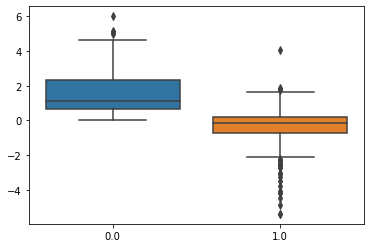

In [103]:
sns.boxplot( x=acceptance_list,y=delta_u_list)

In [104]:
# move every single bead in the chain and this is one step
np.sum(acceptance_list)/len(acceptance_list)

0.7265625

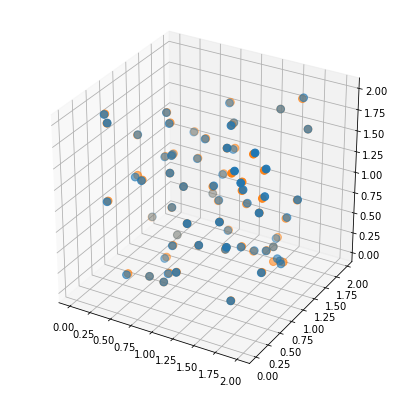

In [105]:
# looking at the differences between the chains

# plot them 
plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.scatter3D(initial_chain[:,0], initial_chain[:,1], initial_chain[:,2], s=60);
ax.scatter3D(current_chain[:,0], current_chain[:,1], current_chain[:,2], s=60);

# Iteration of many montecarlo steps

In [119]:
# number of montecalo steps
N_montecarlo = 20
turn_of_fields = True
current_chain = initial_chain.copy()

# save for each step
accept_ratios = []
# energy
delta_u_list = []
# positions
montecarlo_chains = []

# meassure time taken
start = time.time()
print("Starting")

for j in range(N_montecarlo):
    acceptance_list = np.zeros(Nx)
    # one montecarlo step
    for i in range(0,Nx):
        next_chain, bead_i = move_bead(current_chain,d)
        # if the displacement takes the bead out of the box then we reject the move immediately
        if all((y <= L) and (y>=0) for y in next_chain[bead_i]):
            # calculate initial and final energies
            u0,sumwa0, sumwb0, sum0 = calculate_energy(current_chain,no_fields=turn_of_fields)
            uf,sumwaf, sumwbf, sumf = calculate_energy(next_chain,no_fields=turn_of_fields)

            delta_u = uf-u0

            # metropolis step 
            current_chain, acceptance_list[i] = metropolis_step(delta_u, current_chain, next_chain)
            if acceptance_list[i] == 0:
                delta_u = 0
                
        # reject the move if the bead goes out of the box
        else:
            acceptance_list[i] = 0 
            current_chain = current_chain.copy()
            # delta u of zero means that the move was rejected because it steped out of the box
            deta_u = 0
            
    # save data
    acceptance_ratio = np.sum(acceptance_list)/len(acceptance_list)
    accept_ratios.append(acceptance_ratio)
    delta_u_list.append(delta_u)
    montecarlo_chains.append(current_chain)
            
    # print the time yo look at something while it iterates
    if(j%100==0):
        now = time.time()
        print("{0} seconds since the loop started".format(now - start), " and ", j+1, "iterations")

end = time.time()
print(end - start)

Starting
1.4438869953155518 seconds since the loop started  and  1 iterations
30.12802505493164


In [120]:
# save the data
np.savetxt('acceptance_ratio.csv', accept_ratios, delimiter=',')
np.savetxt('energy_changes.csv', delta_u_list, delimiter=',')

# save the montecarlo chains
output = open('montecarlo_chains.pkl', 'wb')
pickle.dump(montecarlo_chains, output)
output.close()


In [124]:
was = pd.read_pickle(r'montecarlo_chains.pkl')


In [128]:
aaa = np.loadtxt('acceptance_ratio.csv', delimiter=',')
uuu = np.loadtxt('energy_changes.csv', delimiter=',')


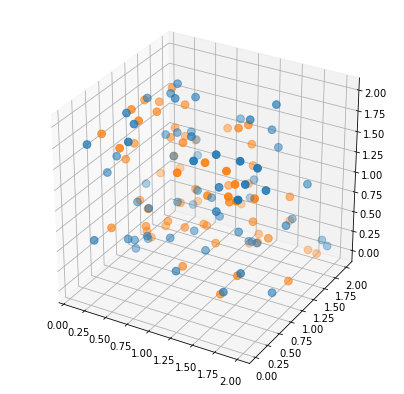

In [126]:
# plot them 
plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.scatter3D(was[0][:,0], was[0][:,1], was[0][:,2], s=60);
ax.scatter3D(was[-1][:,0], was[-1][:,1], was[-1][:,2], s=60);


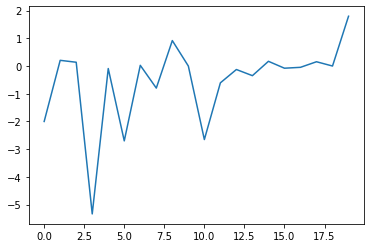

In [129]:
plt.plot(uuu)